In [1]:
# label wdpa_pids as (trend: sig_increase, sig_decrease, no_change, increase, decrease) across all years
# IGNORE figure 1: methods figure of transect idea
# IGNORE figure 2: map of trend. (join spatial information)
# IGNORE figure 2a: sub image of 4 examples 2020 magnitude_gradient image, ndvi_image, raw satellite image; find most edgey ones but for built, vegetation, elevation, water

In [2]:
# figure 3: calculate edge extent as sig_increase, sig_decrease, no_change, increase, decrease, across all years then pool edge_extent by biome in a vertical stacked bar chart showing significant increase, significant decrease, no change, count of WDPA_PID by biome below biome name and % of each category labeled
# figure 4a: edge_extent ~ AREA_DISSO + gHM_mean + ndvi_mean + elevation_mean + slope_mean + water_extent + (1|biome + year)
#           plot this to show relationship between edge_extent and the covariates
# figure 4b: edge_intensity ~ AREA_DISSO + gHM_mean + ndvi_mean + elevation_mean + slope_mean + water_extent + (1|biome + year)
#           plot this to show relationship between edge_intensity and the covariates
# anova for IUCN_CAT, STATUS_YR, biome, AREA_DISSO to check influence
# figure S1: overall distribution of edge_extent and edge_intensity
# figure S2: correlation plot of edge_intensity vs edge_extent

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Load data
wdpa_df = pd.read_parquet("../data/wdpa_df.parquet")

# Recategorize BIOME_NAME
def recategorize_biome(biome):
    if biome == "Mangroves":
        return "Mangrove"
    elif biome == "N/A":
        return "Rock & Ice"
    elif biome in ["Deserts & Xeric Shrublands"]:
        return "Desert"
    elif biome in ["Tropical & Subtropical Coniferous Forests",
                   "Tropical & Subtropical Moist Broadleaf Forests",
                   "Tropical & Subtropical Dry Broadleaf Forests"]:
        return "Tropical-Forests"
    elif biome in ["Mediterranean Forests, Woodlands & Scrub",
                   "Temperate Conifer Forests",
                   "Temperate Broadleaf & Mixed Forests"]:
        return "Temperate-Forests"
    elif biome in ["Boreal Forests/Taiga"]:
        return "Boreal-Forests"
    elif biome in ["Tropical & Subtropical Grasslands, Savannas & Shrublands",
                   "Temperate Grasslands, Savannas & Shrublands",
                   "Montane Grasslands & Shrublands",
                   "Flooded Grasslands & Savannas"]:
        return "Grassland-Shrubland"
    else:
        return biome

wdpa_df['BIOME_NAME'] = wdpa_df['BIOME_NAME'].apply(recategorize_biome)

# Calculate trend for each WDPA_PID using linear regression
def classify_trend(group):
    X = group['year'].values
    y = group['edge_extent'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    
    if p_value < 0.05:
        if slope > 0:
            return 'sig_increase'
        else:
            return 'sig_decrease'
    else:
        if slope > 0:
            return 'increase'
        elif slope < 0:
            return 'decrease'
        else:
            return 'no_change'

trend_df = wdpa_df.groupby('WDPA_PID').apply(classify_trend).reset_index()
trend_df.columns = ['WDPA_PID', 'trend']

# Merge trend back to wdpa_df
wdpa_df = wdpa_df.merge(trend_df, on='WDPA_PID', how='left')

print(f"Trend distribution:\n{wdpa_df.groupby('WDPA_PID')['trend'].first().value_counts()}")

Trend distribution:
trend
increase        1664
decrease        1549
sig_increase     370
sig_decrease     355
no_change          1
Name: count, dtype: int64


/tmp/ipykernel_27016/2739365927.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_df = wdpa_df.groupby('WDPA_PID').apply(classify_trend).reset_index()


In [4]:
wdpa_df.head()

,WDPA_PID,year,n_trnst,D02,D01,D0m1,D0m2,edge_intensity,edge_extent,gHM_mean,...,slope_mean,water_extent_pct,ORIG_NAME,ISO3,PERIMETER,AREA_DISSO,IUCN_CAT,STATUS_YR,BIOME_NAME,trend
0,100017,2001,863,0.096855,0.108141,0.696113,0.782410,0.096855,0.618772,0.18173,...,2.401095,20.393975,"Государственный национальный природный парк ""А...",KAZ,582579.791497,3.117769e+09,II,1996,Grassland-Shrubland,increase
1,100017,2002,863,0.174973,0.244196,0.693921,0.756960,0.174973,0.604867,0.18173,...,2.401095,20.393975,"Государственный национальный природный парк ""А...",KAZ,582579.791497,3.117769e+09,II,1996,Grassland-Shrubland,increase
2,100017,2003,863,0.259872,0.139321,0.611114,0.699699,0.139321,0.615295,0.18173,...,2.401095,20.393975,"Государственный национальный природный парк ""А...",KAZ,582579.791497,3.117769e+09,II,1996,Grassland-Shrubland,increase
3,100017,2004,863,0.083861,0.118458,0.664082,0.732067,0.083861,0.594438,0.18173,...,2.401095,20.393975,"Государственный национальный природный парк ""А...",KAZ,582579.791497,3.117769e+09,II,1996,Grassland-Shrubland,increase
4,100017,2005,863,0.303871,0.206119,0.702197,0.759316,0.206119,0.617613,0.18173,...,2.401095,20.393975,"Государственный национальный природный парк ""А...",KAZ,582579.791497,3.117769e+09,II,1996,Grassland-Shrubland,increase


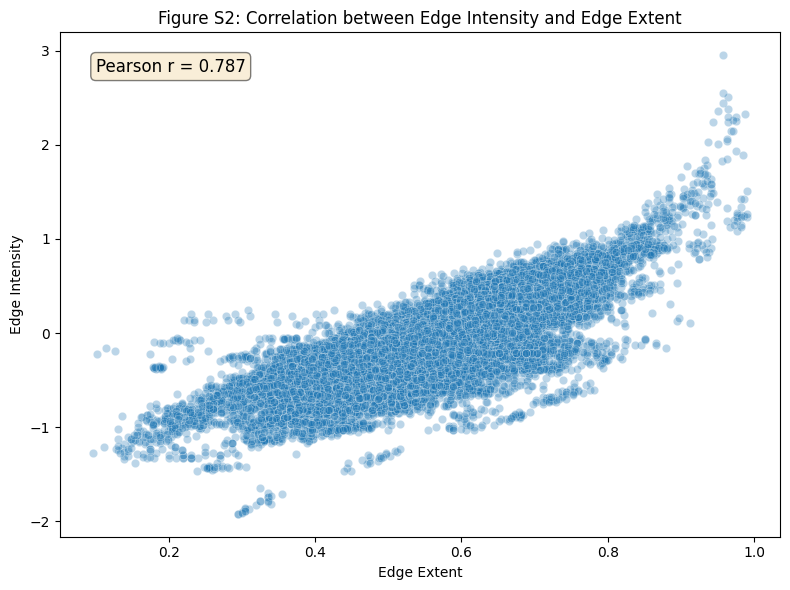

In [5]:
# Figure S2: Correlation between edge_intensity and edge_extent
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with density
sns.scatterplot(data=wdpa_df, x='edge_extent', y='edge_intensity', alpha=0.3, ax=ax)

# Add correlation
corr = wdpa_df[['edge_extent', 'edge_intensity']].corr().iloc[0, 1]
ax.text(0.05, 0.95, f'Pearson r = {corr:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add regression line
z = np.polyfit(wdpa_df['edge_extent'], wdpa_df['edge_intensity'], 1)
p = np.poly1d(z)
x_line = np.linspace(wdpa_df['edge_extent'].min(), wdpa_df['edge_extent'].max(), 100)
ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

ax.set_xlabel('Edge Extent')
ax.set_ylabel('Edge Intensity')
ax.set_title('Figure S2: Correlation between Edge Intensity and Edge Extent')
plt.tight_layout()
plt.savefig('../results/figureS2_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

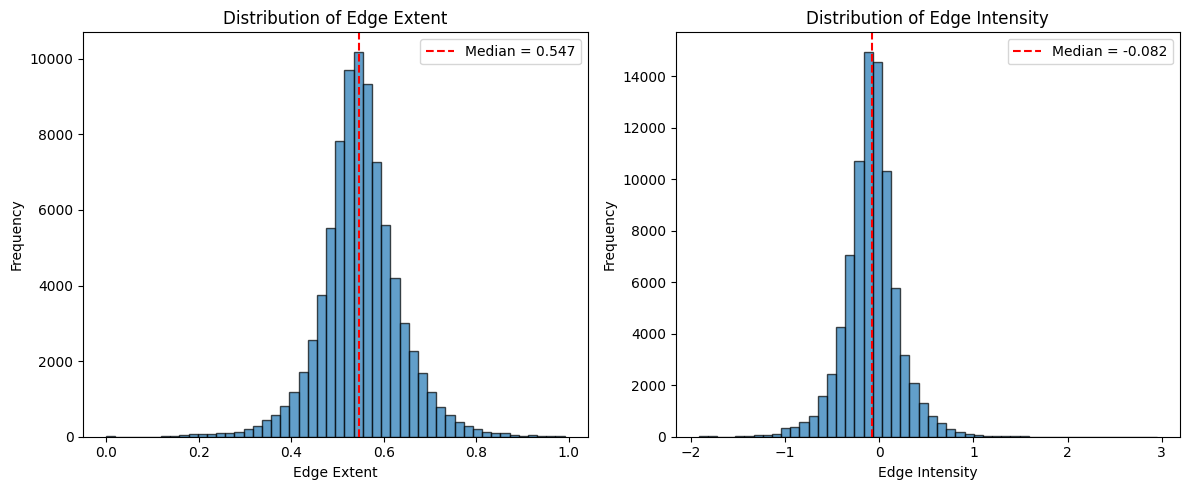

In [6]:
# Figure S1: Distribution of edge_extent and edge_intensity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Edge extent distribution
axes[0].hist(wdpa_df['edge_extent'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(wdpa_df['edge_extent'].median(), color='red', linestyle='--', 
                label=f'Median = {wdpa_df["edge_extent"].median():.3f}')
axes[0].set_xlabel('Edge Extent')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Edge Extent')
axes[0].legend()

# Edge intensity distribution
axes[1].hist(wdpa_df['edge_intensity'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(wdpa_df['edge_intensity'].median(), color='red', linestyle='--',
                label=f'Median = {wdpa_df["edge_intensity"].median():.3f}')
axes[1].set_xlabel('Edge Intensity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Edge Intensity')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/figureS1_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# ANOVA for categorical predictors
anova_df = wdpa_df[['edge_extent', 'IUCN_CAT', 'STATUS_YR', 'BIOME_NAME', 'AREA_DISSO']].dropna()

# IUCN_CAT
model_iucn = ols('edge_extent ~ C(IUCN_CAT)', data=anova_df).fit()
print("ANOVA for IUCN_CAT:")
print(anova_lm(model_iucn, typ=2))
print("\n")

# STATUS_YR
model_status = ols('edge_extent ~ STATUS_YR', data=anova_df).fit()
print("ANOVA for STATUS_YR:")
print(anova_lm(model_status, typ=2))
print("\n")

# biome
model_biome = ols('edge_extent ~ C(BIOME_NAME)', data=anova_df).fit()
print("ANOVA for biome:")
print(anova_lm(model_biome, typ=2))
print("\n")

# AREA_DISSO
model_area = ols('edge_extent ~ AREA_DISSO', data=anova_df).fit()
print("ANOVA for AREA_DISSO:")
print(anova_lm(model_area, typ=2))

ANOVA for IUCN_CAT:
                 sum_sq       df          F         PR(>F)
C(IUCN_CAT)    6.231664      9.0  95.733102  1.042985e-178
Residual     596.992810  82541.0        NaN            NaN


ANOVA for STATUS_YR:
               sum_sq       df          F    PR(>F)
STATUS_YR    0.081424      1.0  11.144128  0.000843
Residual   603.143049  82549.0        NaN       NaN


ANOVA for biome:
                   sum_sq       df           F  PR(>F)
C(BIOME_NAME)   14.243040      7.0  285.156523     0.0
Residual       588.981433  82543.0         NaN     NaN


ANOVA for AREA_DISSO:
                sum_sq       df          F        PR(>F)
AREA_DISSO    0.539648      1.0  73.914952  8.295293e-18
Residual    602.684826  82549.0        NaN           NaN


            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: edge_intensity
No. Observations:   77217   Method:             REML          
No. Groups:         8       Scale:              0.0800        
Min. group size:    231     Log-Likelihood:     -12121.0472   
Max. group size:    26691   Converged:          Yes           
Mean group size:    9652.1                                    
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          -0.157    0.042  -3.752 0.000 -0.238 -0.075
AREA_DISSO_z        0.023    0.001  21.800 0.000  0.021  0.025
gHM_mean_z         -0.001    0.001  -1.249 0.212 -0.004  0.001
elevation_mean_z   -0.010    0.002  -6.595 0.000 -0.013 -0.007
slope_mean_z       -0.054    0.002 -34.320 0.000 -0.057 -0.051
water_extent_pct_z -0.005    0.001  -4.619 0.000 -0.007 -0.003
Group

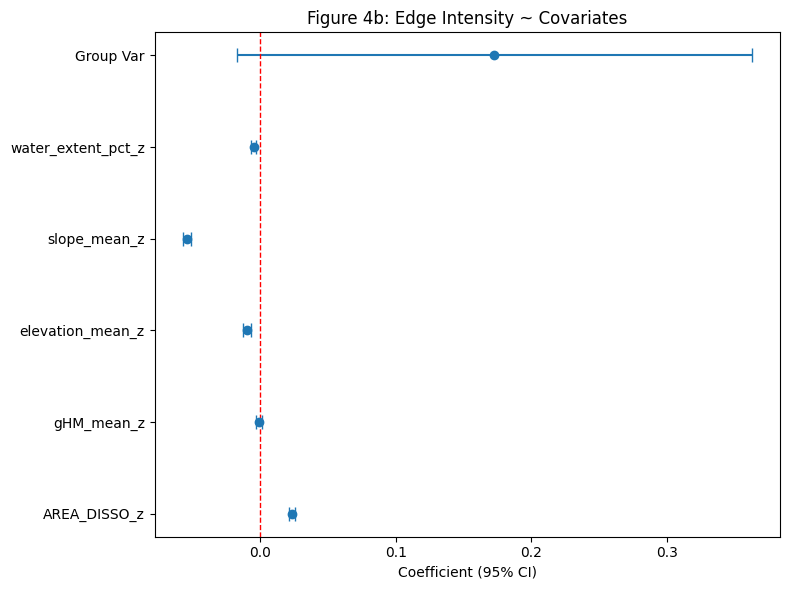

In [8]:
# Figure 4b: Mixed model for edge_intensity
model_df2 = wdpa_df[['edge_intensity', 'AREA_DISSO', 'gHM_mean', 'elevation_mean', 
                      'slope_mean', 'water_extent_pct', 'BIOME_NAME', 'year', 'WDPA_PID']].dropna()

# Standardize continuous predictors
for col in ['AREA_DISSO', 'gHM_mean', 'elevation_mean', 'slope_mean', 'water_extent_pct']:
    model_df2[f'{col}_z'] = (model_df2[col] - model_df2[col].mean()) / model_df2[col].std()

# Fit mixed model
md2 = MixedLM.from_formula(
    'edge_intensity ~ AREA_DISSO_z + gHM_mean_z + elevation_mean_z + slope_mean_z + water_extent_pct_z',
    data=model_df2,
    groups=model_df2['BIOME_NAME'],
    re_formula='1'
)
mdf2 = md2.fit()
print(mdf2.summary())

# Plot coefficients
coef_df2 = pd.DataFrame({
    'Variable': mdf2.params.index[1:],
    'Coefficient': mdf2.params.values[1:],
    'CI_lower': mdf2.conf_int().iloc[1:, 0],
    'CI_upper': mdf2.conf_int().iloc[1:, 1]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(coef_df2['Coefficient'], range(len(coef_df2)), 
            xerr=[coef_df2['Coefficient'] - coef_df2['CI_lower'], 
                  coef_df2['CI_upper'] - coef_df2['Coefficient']],
            fmt='o', capsize=5)
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_yticks(range(len(coef_df2)))
ax.set_yticklabels(coef_df2['Variable'])
ax.set_xlabel('Coefficient (95% CI)')
ax.set_title('Figure 4b: Edge Intensity ~ Covariates')
plt.tight_layout()
plt.savefig('../results/figure4b_edge_intensity_model.png', dpi=300, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  edge_extent
No. Observations:    77217    Method:              REML       
No. Groups:          8        Scale:               0.0066     
Min. group size:     231      Log-Likelihood:      84279.7812 
Max. group size:     26691    Converged:           Yes        
Mean group size:     9652.1                                   
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           0.533    0.008  70.094 0.000  0.518  0.548
AREA_DISSO_z        0.002    0.000   7.352 0.000  0.002  0.003
gHM_mean_z          0.004    0.000  12.963 0.000  0.004  0.005
elevation_mean_z   -0.007    0.000 -14.768 0.000 -0.007 -0.006
slope_mean_z       -0.017    0.000 -37.494 0.000 -0.018 -0.016
water_extent_pct_z  0.010    0.000  32.343 0.000  0.010  0.011
Group

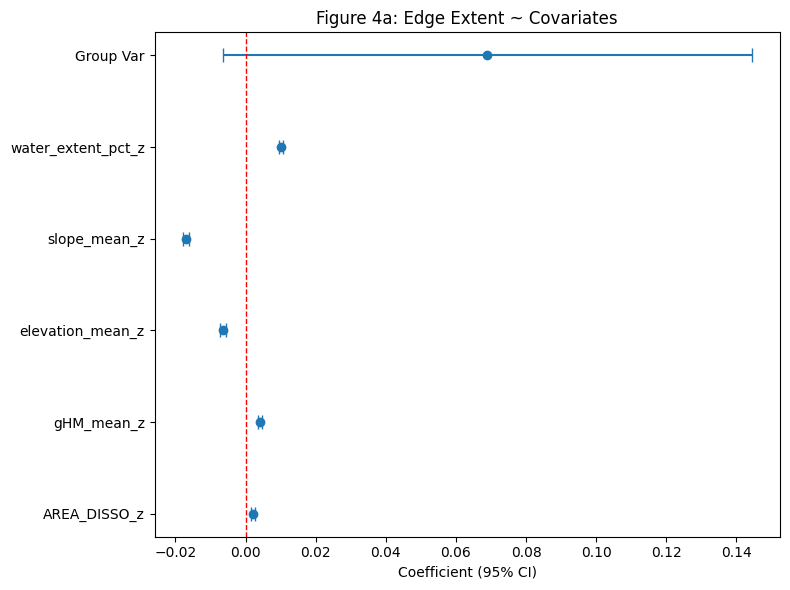

In [9]:
# Figure 4a: Mixed model for edge_extent
model_df = wdpa_df[['edge_extent', 'AREA_DISSO', 'gHM_mean', 'elevation_mean', 
                     'slope_mean', 'water_extent_pct', 'BIOME_NAME', 'year', 'WDPA_PID']].dropna()

# Standardize continuous predictors
for col in ['AREA_DISSO', 'gHM_mean', 'elevation_mean', 'slope_mean', 'water_extent_pct']:
    model_df[f'{col}_z'] = (model_df[col] - model_df[col].mean()) / model_df[col].std()

# Fit mixed model with biome and year as random effects
md = MixedLM.from_formula(
    'edge_extent ~ AREA_DISSO_z + gHM_mean_z + elevation_mean_z + slope_mean_z + water_extent_pct_z',
    data=model_df,
    groups=model_df['BIOME_NAME'],
    re_formula='1'
)
mdf = md.fit()
print(mdf.summary())

# Plot coefficients
coef_df = pd.DataFrame({
    'Variable': mdf.params.index[1:],  # Skip intercept
    'Coefficient': mdf.params.values[1:],
    'CI_lower': mdf.conf_int().iloc[1:, 0],
    'CI_upper': mdf.conf_int().iloc[1:, 1]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(coef_df['Coefficient'], range(len(coef_df)), 
            xerr=[coef_df['Coefficient'] - coef_df['CI_lower'], 
                  coef_df['CI_upper'] - coef_df['Coefficient']],
            fmt='o', capsize=5)
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_yticks(range(len(coef_df)))
ax.set_yticklabels(coef_df['Variable'])
ax.set_xlabel('Coefficient (95% CI)')
ax.set_title('Figure 4a: Edge Extent ~ Covariates')
plt.tight_layout()
plt.savefig('../results/figure4a_edge_extent_model.png', dpi=300, bbox_inches='tight')
plt.show()

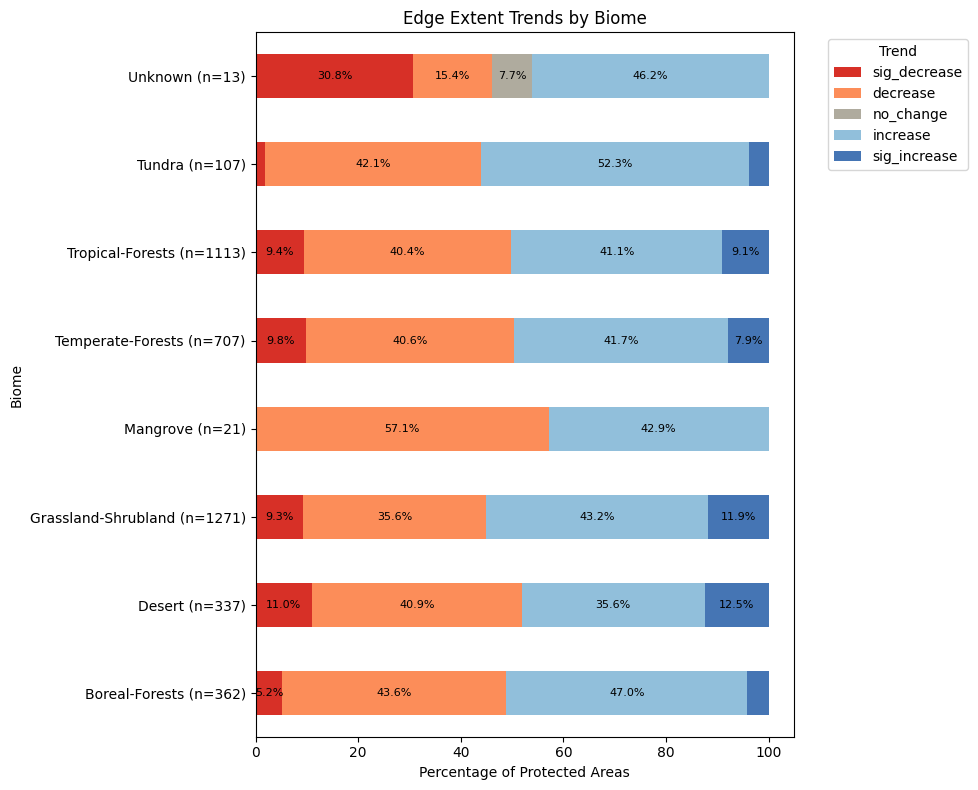

In [10]:
# Figure 3: Stacked bar chart of trend by biome (horizontal)
trend_by_biome = wdpa_df.groupby(['BIOME_NAME', 'WDPA_PID'])['trend'].first().reset_index()
trend_counts = trend_by_biome.groupby(['BIOME_NAME', 'trend']).size().unstack(fill_value=0)

# Reorder columns
col_order = ['sig_decrease', 'decrease', 'no_change', 'increase', 'sig_increase']
trend_counts = trend_counts[[c for c in col_order if c in trend_counts.columns]]

# Calculate percentages
trend_pcts = trend_counts.div(trend_counts.sum(axis=1), axis=0) * 100

# Plot horizontal
fig, ax = plt.subplots(figsize=(10, 8))
trend_pcts.plot(kind='barh', stacked=True, ax=ax, 
                color=['#d73027', '#fc8d59', "#afab9e", '#91bfdb', '#4575b4'])

# Add count labels after biome names
biome_counts = trend_counts.sum(axis=1)
ax.set_yticklabels([f"{biome} (n={biome_counts[biome]})" for biome in trend_pcts.index])

# Add percentage labels on bars
for i, biome in enumerate(trend_pcts.index):
    cumulative = 0
    for col in trend_pcts.columns:
        val = trend_pcts.loc[biome, col]
        if val > 5:  # Only label if > 5%
            ax.text(cumulative + val/2, i, f'{val:.1f}%', 
                   ha='center', va='center', fontsize=8)
        cumulative += val

ax.set_xlabel('Percentage of Protected Areas')
ax.set_ylabel('Biome')
ax.legend(title='Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('Edge Extent Trends by Biome')
plt.tight_layout()
plt.savefig('../results/figure3_trends_by_biome.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# calculate the following summary statistics:
# total number of unique WDPA_PID
# total number of transects
# total number of unique ISO3
# total number of unique biome
# total number of WDPA_PID per biome
# percent and number of WDPA_PID edge_extent < 10%
# percent and number of WDPA_PID edge_intensity < 0

In [12]:
# Summary Statistics
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

# Total unique WDPA_PIDs
n_wdpa = wdpa_df['WDPA_PID'].nunique()
print(f"Total number of unique WDPA_PID: {n_wdpa:,}")

# Total transects (sum of n_trnst)
total_transects = wdpa_df.groupby('WDPA_PID')['n_trnst'].first().sum()
print(f"Total number of transects: {total_transects:,}")

# Total unique ISO3
n_iso3 = wdpa_df['ISO3'].nunique()
print(f"Total number of unique ISO3: {n_iso3:,}")

# Total unique biomes
n_biome = wdpa_df['BIOME_NAME'].nunique()
print(f"Total number of unique biome: {n_biome:,}")

# Number of WDPA_PID per biome
print("\nNumber of WDPA_PID per biome:")
print(wdpa_df.groupby('BIOME_NAME')['WDPA_PID'].nunique().sort_values(ascending=False))

# Edge extent < 10%
wdpa_summary = wdpa_df.groupby('WDPA_PID').agg({
    'edge_extent': 'mean',
    'edge_intensity': 'mean'
}).reset_index()

low_extent = (wdpa_summary['edge_extent'] < 0.1).sum()
low_extent_pct = (low_extent / len(wdpa_summary)) * 100
print(f"\nWDPA_PID with edge_extent < 10%: {low_extent:,} ({low_extent_pct:.1f}%)")

# Edge intensity < 0
low_intensity = (wdpa_summary['edge_intensity'] < 0).sum()
low_intensity_pct = (low_intensity / len(wdpa_summary)) * 100
print(f"WDPA_PID with edge_intensity < 0: {low_intensity:,} ({low_intensity_pct:.1f}%)")
print("=" * 60)

SUMMARY STATISTICS
Total number of unique WDPA_PID: 3,939
Total number of transects: 1,730,085
Total number of unique ISO3: 148
Total number of unique biome: 8

Number of WDPA_PID per biome:
BIOME_NAME
Grassland-Shrubland    1271
Tropical-Forests       1113
Temperate-Forests       707
Boreal-Forests          362
Desert                  337
Tundra                  107
Mangrove                 21
Unknown                  13
Name: WDPA_PID, dtype: int64

WDPA_PID with edge_extent < 10%: 1 (0.0%)
WDPA_PID with edge_intensity < 0: 2,703 (68.6%)
